# Comparing Vegas generated without scanning with the KDE prediction in observables

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis
from plot_utils import *
from dark_nus_utils import load_datasets

## Get objects for all 4 cases 

In [3]:
my_exp_analyses = load_datasets(['light'])

light dirac
loading df base
initialising df base
loading df 0.1, 0.01
initialising df 0.1, 0.01
loading df 0.1, 0.03
initialising df 0.1, 0.03
loading df 0.4, 0.01
initialising df 0.4, 0.01
loading df 0.4, 0.03
initialising df 0.4, 0.03
loading df 0.4, 0.1
initialising df 0.4, 0.1
loading df 0.4, 0.2
initialising df 0.4, 0.2
loading df 0.8, 0.01
initialising df 0.8, 0.01
loading df 0.8, 0.03
initialising df 0.8, 0.03
loading df 0.8, 0.1
initialising df 0.8, 0.1
loading df 0.8, 0.2
initialising df 0.8, 0.2
light majorana
loading df base
initialising df base
loading df 0.1, 0.01
initialising df 0.1, 0.01
loading df 0.1, 0.03
initialising df 0.1, 0.03
loading df 0.4, 0.01
initialising df 0.4, 0.01
loading df 0.4, 0.03
initialising df 0.4, 0.03
loading df 0.4, 0.1
initialising df 0.4, 0.1
loading df 0.4, 0.2
initialising df 0.4, 0.2
loading df 0.8, 0.01
initialising df 0.8, 0.01
loading df 0.8, 0.03
initialising df 0.8, 0.03
loading df 0.8, 0.1
initialising df 0.8, 0.1
loading df 0.8, 0.2


In [4]:
load_all=True

In [5]:
if load_all:
    my_exp_analyses = {}
    from itertools import product
    for hierarchy, D_or_M in product(['heavy'], ['dirac', 'majorana']):
        print(hierarchy, D_or_M)
        save_folder = f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/'
        !mkdir -p $save_folder
        this_exp_analyis = exp_analysis(hierarchy, D_or_M)
        this_exp_analyis.load_df_base(1000000)
        this_exp_analyis.load_grid_dfs()
        my_exp_analyses[f'{hierarchy}_{D_or_M}'] = this_exp_analyis

heavy dirac
loading df base
initialising df base
loading df 0.01, 0.1
initialising df 0.01, 0.1
loading df 0.01, 1
initialising df 0.01, 1
loading df 0.01, 5
initialising df 0.01, 5
loading df 0.1, 1
initialising df 0.1, 1
loading df 0.1, 5
initialising df 0.1, 5
loading df 0.5, 1
initialising df 0.5, 1
loading df 0.5, 5
initialising df 0.5, 5
heavy majorana
loading df base
initialising df base
loading df 0.01, 0.1
initialising df 0.01, 0.1
loading df 0.01, 1
initialising df 0.01, 1
loading df 0.01, 5
initialising df 0.01, 5
loading df 0.1, 1
initialising df 0.1, 1
loading df 0.1, 5
initialising df 0.1, 5
loading df 0.5, 1
initialising df 0.5, 1
loading df 0.5, 5
initialising df 0.5, 5


##### Examples

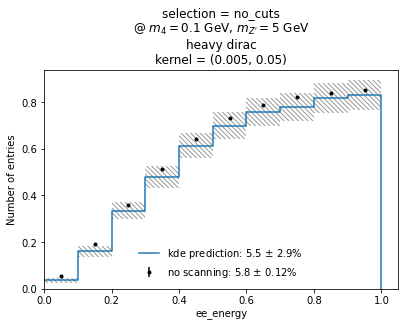

In [11]:
kde_to_noscan_comparison(var='ee_energy',
                       range=(0, 1),
                       bins=10,
                       m4mz=(0.1, 5),
                       exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                       smoothing_pars=(0.005, 0.05),
                       selection_query='no_cuts',
                       cumulative=True)

In [8]:
kde_to_noscan_comparison(var='pee_t',
                       range=(0, 1),
                       bins=10,
                       m4mz=(0.1, 5),
                       exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                       smoothing_pars=(0.005, 0.05),
                       selection_query='no_cuts',
                       cumulative=True)

KeyError: 'pee_t'

In [7]:
comparison_plot_models(var='pee_t',
                       range=(0, 1),
                       bins=10,
                       m4mz=(0.1, 0.03),
                       exp_analysis_objs=[my_exp_analyses['light_dirac'], my_exp_analyses['light_majorana']],
                       existing_axes=None,
                       smoothing_pars=(0.005, 0.05),
                       selection_query='no_cuts',
                       cumulative=True);

KeyError: 'light_dirac'

In [ ]:
comparison_plot_cuts(var='pee_t',
                       range=(0, 2),
                       bins=10,
                       m4mz=(0.1, 1),
                       exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                       smoothing_pars=(0.005, 0.05),
                       selection_queries=['no_cuts', 'cut1', 'cut2'],
                       cumulative=True);

## Efficiency

### Single efficiency for KDE

In [ ]:
kde_efficiency(num_selection_query='cut1',
               den_selection_query='no_cuts',
               m4mz=(0.1, 0.5),
               exp_analysis_obj=my_exp_analyses['heavy_dirac']
               )

### Single efficiency for no scan

In [ ]:
no_scan_efficiency(num_selection_query='cut1',
               den_selection_query='no_cuts',
               m4mz=(0.1, 1),
               exp_analysis_obj=my_exp_analyses['heavy_dirac']
               )

### Efficiency on the m4,mz grid

In [ ]:
kde_no_scan_efficiency_plot_grid(num_selection_query='cut1',
                                 den_selection_query='no_cuts',
                                 exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                                 smoothing_pars=[0.005, 0.05]);

### Efficiency for multiple cuts

In [ ]:
kde_no_scan_efficiency_cut_list(num_selection_queries=['(cut1 & cut2)', 'cut2', 'cut3', 'cut4', 'cut_based'], 
                                den_selection_queries='decay_in_tpc_10', 
                                exp_analysis_obj=my_exp_analyses['heavy_dirac'], 
                                m4mz=(0.1, 1),
                                smoothing_pars=[0.005, 0.05])

### Efficiency for multiple c$\tau$ (finally!!!)

In [ ]:
ctaus = [1, 10, 100, 1000, 10000]
my_exp_analyses['heavy_dirac'].ctau_acceptance(ctaus)

kde_no_scan_efficiency_cut_list(num_selection_queries=[f'decay_in_tpc_{ctau}' for ctau in ctaus], 
                                den_selection_queries='no_cuts', 
                                exp_analysis_obj=my_exp_analyses['heavy_dirac'], 
                                m4mz=(0.1, 1),
                                smoothing_pars=[0.005, 0.05]);
plt.xticks(range(len(ctaus)), labels=[f'c$\\tau$ = {ctau}' for ctau in ctaus]);

## Comparison N events for different cuts and different c$\tau$

### For different cuts

In [ ]:
selections = ['cut1', 'cut2', 'cut3', 'cut4', 'cut_based']

for selection in selections:
    fig, axes = plt.subplots(nrows=1, ncols=len(my_exp_analyses), figsize=(len(my_exp_analyses)*5, 5))
    plt.suptitle(r'N events KDE / generated without scan')

    for my_exp_analysis, ax in zip(my_exp_analyses.values(), axes):
        print(my_exp_analysis.hierarchy, my_exp_analysis.D_or_M)
        n_events_grid_no_scan = my_exp_analysis.no_scan_benchmark_grid(lambda x: x.query(selection)['actual_weight'].sum())
        n_events_err_kde = my_exp_analysis.kde_n_events_benchmark_grid(selection_query=selection,
                                                                       smoothing=general_smoothing_pars)
        n_events_kde = n_events_err_kde[..., 0]
        n_events_kde_err = n_events_err_kde[..., 1]

        plt.sca(ax)
        annotated_2d_plot(data=n_events_kde/n_events_grid_no_scan,
                          xcenters=my_exp_analysis.m4_scan,
                          ycenters=my_exp_analysis.mz_scan,
                          xlabel =r'$m_4$ [GeV]',
                          ylabel=r'$m_Z$ [GeV]',
                          vmin=0.5,
                          vmax=1.5,
                          errors_to_annotate=n_events_kde_err/n_events_grid_no_scan
                          )

        set_plot_title(exp_analysis_obj=my_exp_analysis, 
                       smoothing_pars=general_smoothing_pars,
                       selection_query=selection)
    plt.colorbar()
    plt.savefig(f'../fig/3_comparison_observables/N_selection_{selection}.pdf', bbox_inches='tight')
    plt.close()

### For different c$\tau$

In [ ]:
ctaus = [1, 10, 100, 1000]

for ctau in ctaus:
    fig, axes = plt.subplots(nrows=1, ncols=len(my_exp_analyses), figsize=(len(my_exp_analyses)*5, 5))
    plt.suptitle(r'N events KDE / generated without scan')

    for my_exp_analysis, ax in zip(my_exp_analyses.values(), axes):
        my_exp_analysis.ctau_acceptance(ctau)
        print(my_exp_analysis.hierarchy, my_exp_analysis.D_or_M)
        sel_query = f'decay_in_tpc_{ctau}'
        n_events_grid_no_scan = my_exp_analysis.no_scan_benchmark_grid(lambda x: x.query(sel_query)['actual_weight'].sum())
        n_events_err_kde = my_exp_analysis.kde_n_events_benchmark_grid(selection_query=sel_query,
                                                                       smoothing=general_smoothing_pars)
        n_events_kde = n_events_err_kde[..., 0]
        n_events_kde_err = n_events_err_kde[..., 1]

        plt.sca(ax)
        annotated_2d_plot(data=n_events_kde/n_events_grid_no_scan,
                          xcenters=my_exp_analysis.m4_scan,
                          ycenters=my_exp_analysis.mz_scan,
                          xlabel =r'$m_4$ [GeV]',
                          ylabel=r'$m_Z$ [GeV]',
                          vmin=0.5,
                          vmax=1.5,
                          errors_to_annotate=n_events_kde_err/n_events_grid_no_scan
                          )

        set_plot_title(exp_analysis_obj=my_exp_analysis, 
                       smoothing_pars=general_smoothing_pars,
                       selection_query=sel_query)
    plt.colorbar()
    plt.savefig(f'../fig/3_comparison_observables/N_ctau_{ctau}.pdf', bbox_inches='tight')
    plt.close()

## Example of plotting comparisons for a single observable -- ee energy
## It needs to be updated!

In [ ]:
bins = 10
var1='ee_energy'
var2=''
varmin=0; varmax=1.0
fig,  axes = plt.subplots(nrows=1, ncols=4,figsize = (18,4))

# Heavy
m4mz = (0.1, 1)
smooth=(0.02,0.01)
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm]
batch_comparison_plot(axes[:2],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

# light
m4mz = (0.4, 0.1)
smooth=(0.02,0.02)
exp_analyses=[my_exp_analysis_ld,my_exp_analysis_lm]
batch_comparison_plot(axes[2:],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

plt.tight_layout()

## Comparing (heavy light)(maj dir) for all variables 

plots stored in multi-page pdf in plots/generation_KDE_comparisons/

In [ ]:
%%capture
m4mzheavy= (0.1, 1)
m4mzlight = (0.4, 0.03)

# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

In [ ]:
%%capture
m4mzheavy= (0.01, 1)
m4mzlight = (0.4, 0.03)

s# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

## Compare different cut stages for a single (heavy light)(maj dir) case

In [ ]:
%%capture
m4mz= (0.1, 0.03)

exp_analyses=[my_exp_analysis_lm]*4
# varying var range for light case -- standard def is better for heavy case
var_range = [(0,1.0),
            (0,np.pi/4),
            (0,m4mz[0]),
            (-1,1.0),
            (0,np.pi/4),
            (0,np.pi/4),
            (0,0.01)]
smooth_light=(0.02,0.02)
batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, smooth = smooth_light,
                           var_range=var_range,
                           sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])  

In [ ]:
%%capture
m4mz= (0.1, 1)
exp_analyses=[my_exp_analysis_hm]*4

batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])